In [1]:
import sys

import matplotlib.pyplot as plt

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/bruno-pacheco/brain-age')

from tqdm.notebook import tqdm

import numpy as np

In [2]:
from brats.utils import show_mri

In [3]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age'):
    best_model_file = wandb.restore(
        'model_best.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [4]:
import h5py

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix.hdf5', dataset='test')
len(val_data)

41360

# 1 mm³

In [32]:
val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix.hdf5', dataset='test')
len(val_data)

41360

# Training from 0

### U-Net

In [6]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, '2a1ch4a0').to(device)
net.eval()
net



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [7]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)

Per-image MAE   = 3.9730
Per-subject MAE = 3.4939 (mean agg)
Per-subject MAE = 3.5057 (median agg)


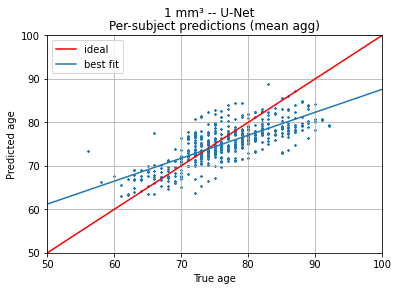

In [17]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('1 mm³ -- U-Net')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

### ResNet50

In [21]:
net = models.resnet50(pretrained=False)
net.fc = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Linear(1024, 1))
net = load_from_wandb(net, '2oyouh2z').to(device)
net.eval()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X.repeat(1,3,1,1)).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)[...,0]

Per-image MAE   = 5.1139
Per-subject MAE = 5.1138 (mean agg)
Per-subject MAE = 5.1056 (median agg)


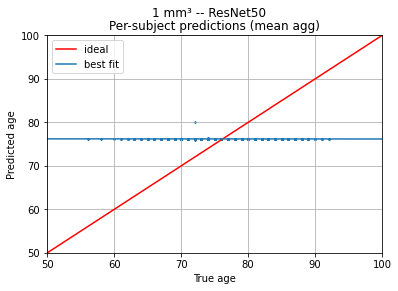

In [31]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('1 mm³ -- ResNet50')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

# Transfer Learning

### U-Net

In [5]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, 'pq3h4jko').to(device)
net.eval()
net



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [6]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)

Per-image MAE   = 3.9161
Per-subject MAE = 3.4552 (mean agg)
Per-subject MAE = 3.4183 (median agg)


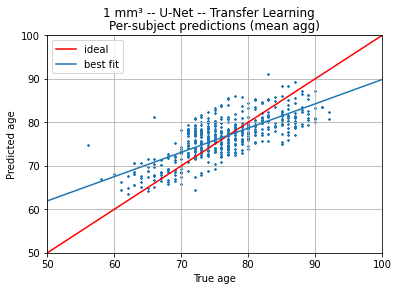

In [7]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('1 mm³ -- U-Net -- Transfer Learning')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

# Fine Tuning

### U-Net

In [8]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, '2dk4cgbi').to(device)
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [9]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)

Per-image MAE   = 3.8931
Per-subject MAE = 3.4489 (mean agg)
Per-subject MAE = 3.4588 (median agg)


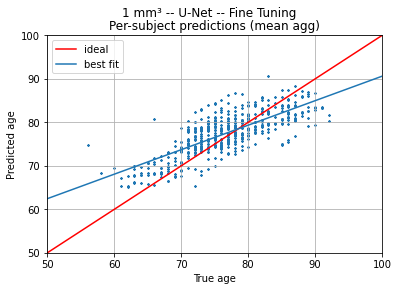

In [11]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('1 mm³ -- U-Net -- Fine Tuning')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

# 2 mm³

In [33]:
val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm.hdf5', dataset='test')
len(val_data)

21160

# Training from 0

### U-Net

In [36]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '2zvz33ee').to(device)
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [37]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)

Per-image MAE   = 4.0496
Per-subject MAE = 3.5515 (mean agg)
Per-subject MAE = 3.5638 (median agg)


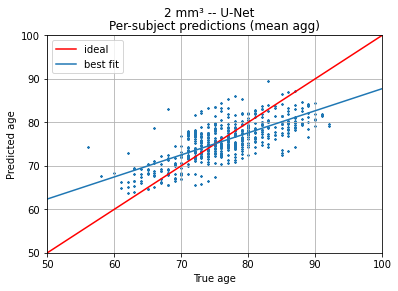

In [40]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('2 mm³ -- U-Net')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

### ResNet50

In [62]:
net = models.resnet50(pretrained=False)
net.fc = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Linear(1024, 1))
net = load_from_wandb(net, '128e21mw').to(device)
net.eval()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X.repeat(1,3,1,1)).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.array(Y)
Y_pred = np.array(Y_pred)[...,0]

Per-image MAE   = 4.5670
Per-subject MAE = 3.9794 (mean agg)
Per-subject MAE = 3.9558 (median agg)


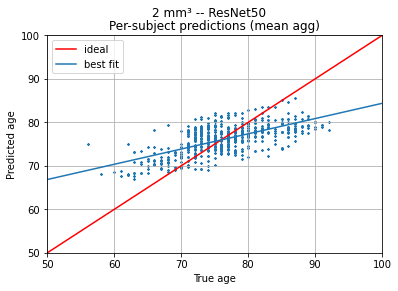

In [64]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('2 mm³ -- ResNet50')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)

plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.gca().set_title('Per-subject predictions (mean agg)')

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

## Transfer Learning

In [19]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, '1i1abwny').to(device)
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [20]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

In [21]:
Y = np.array(Y)
Y_pred = np.array(Y_pred)

# some subjects are 0-aged
Y_pred = Y_pred[(Y != 0).any(axis=-1)]
Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 4.1905
Per-subject MAE = 3.6190 (mean agg)
Per-subject MAE = 3.6125 (median agg)


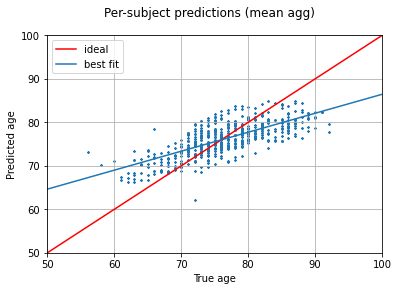

In [22]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('Per-subject predictions (mean agg)')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)
plt.plot()
plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

# Fine Tuning

In [10]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, '21ox5guw').to(device)
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [11]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

In [12]:
Y = np.array(Y)
Y_pred = np.array(Y_pred)

# some subjects are 0-aged
Y_pred = Y_pred[(Y != 0).any(axis=-1)]
Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 3.8117
Per-subject MAE = 3.4891 (mean agg)
Per-subject MAE = 3.4575 (median agg)


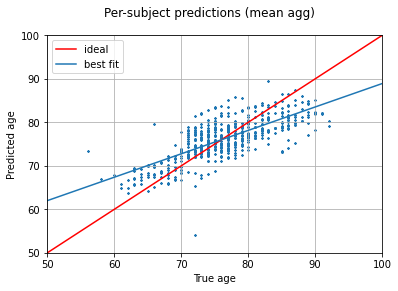

In [18]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('Per-subject predictions (mean agg)')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)
plt.plot()
plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

# Classification

In [24]:
class ClassifierBraTSnnUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,50)
    
    def forward(self, x):
        x = self.pooling(x)

        z = self.fc(x.squeeze()).squeeze()

        return z

net = load_from_wandb(ClassifierBraTSnnUNet(), '1b1mub3z').to(device)
net.eval()
net

ClassifierBraTSnnUNet(
  (pooling): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (fc): Linear(in_features=480, out_features=50, bias=True)
)

In [28]:
val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_features_brats.hdf5', dataset='test', transform=torch.Tensor)
len(val_data)

41600

In [29]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

In [53]:
Y = np.array(Y)
Y_pred = np.array(Y_pred)

# some subjects are 0-aged
Y_pred = Y_pred[(Y != 0).any(axis=-1)]
Y = Y[(Y != 0).any(axis=-1)]

Y_pred = np.argmax(Y_pred, axis=-1) + 50

Per-image MAE   = 4.5354
Per-subject MAE = 3.9110 (mean agg)
Per-subject MAE = 3.9264 (median agg)


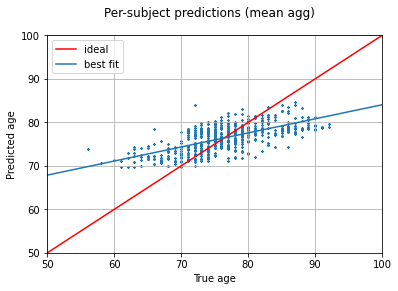

In [54]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('Per-subject predictions (mean agg)')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()

plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

a, b = np.polyfit(Y[:,0], subject_Y_pred, 1)
plt.plot()
plt.plot([0, 100], [b, a * 100 + b], label='best fit')

plt.xlim([50, 100])
plt.ylim([50, 100])

plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.legend()
plt.grid()
plt.show()

In [179]:
val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix.hdf5', dataset='train')

for i in range(len(val_data) // 80):
    y = val_data[80*i][-1]
    if y == 0:
        print(i)

In [176]:
len(val_data) // 80

520

In [76]:
val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)
Y = list()
ii = list()
for i, (_, y) in enumerate(tqdm(val_dataloader)):
#     Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.detach().numpy())
    if (y == 0).any():
        ii.append(i)

In [89]:
ii

[424, 425, 470, 519]

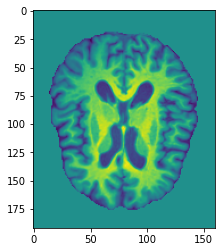

In [153]:
X, y = val_data[424+20]

plt.imshow(X[0].detach().numpy())

In [112]:
import pandas as pd

PREP_DATA_DIR = Path('/home/bruno-pacheco/brain-age/data/raw/ADNI_prep')
SPLIT_CSV_FPATH = Path('/home/bruno-pacheco/brain-age/notebooks/dataframe2D-ADNI.csv')

df = pd.read_csv(SPLIT_CSV_FPATH)
train_sids = df[df['split'] == 'train']['patient'].unique()

train_fpaths_ = [list(PREP_DATA_DIR.glob(f"{sid[5:]}*.nii")) for sid in train_sids]
train_fpaths = list()
for fs in train_fpaths_:
    train_fpaths += fs
train_fpaths = sorted(train_fpaths)

test_fpaths = list(set(PREP_DATA_DIR.glob('*.nii')).difference(set(train_fpaths)))
test_fpaths = sorted(test_fpaths)

In [113]:
len(test_fpaths)

518

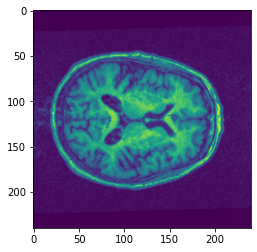

In [164]:
plt.imshow(nib.load(test_fpaths[424]).get_fdata()[:,:,78])

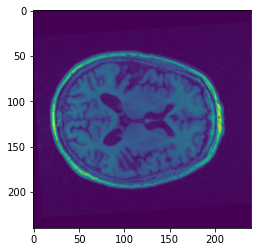

In [173]:
plt.imshow(nib.load(test_fpaths[425]).get_fdata()[:,:,77])

Mean = 76.34
Std  = 6.47


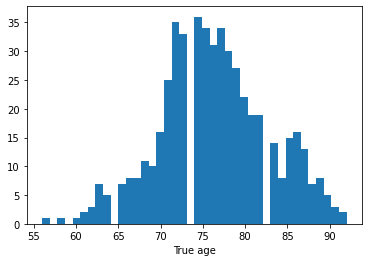

In [105]:
import matplotlib.pyplot as plt

print(f'Mean = {Y[:,0].mean():.2f}')
print(f'Std  = {Y[:,0].std():.2f}')

plt.hist(Y[:,0], bins=40)
plt.xlabel('True age')
plt.show()

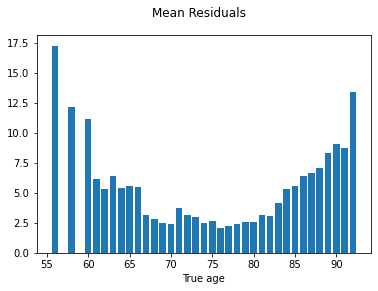

In [141]:
Y_ = Y[:,0]
i_ = np.argsort(Y_)
Y_grouped = np.split(Y_[i_], np.unique(Y_[i_], return_index=True)[1][1:])
grouped_mean_residuals = np.array([np.mean(rs) for rs in np.split(np.abs(subject_Y_pred - Y[:,0])[i_], np.unique(Y_[i_], return_index=True)[1][1:])])

plt.suptitle('Mean Residuals')
plt.bar(np.unique(Y_[i_]), grouped_mean_residuals)
plt.xlabel('True age')
plt.show()